In [2]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, Activation, Dropout, MaxPooling2D
from tensorflow.keras.applications. resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow import optimizers

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
tf.config.list_physical_devices("GPU")

2022-10-25 21:43:33.896392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 21:43:34.150077: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 21:43:34.150763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
data_dir = "/home/luan/Desktop/feijao/Classificacao-main/images_splitted_aug/internas/train"

In [6]:

valid_data_dir = "/home/luan/Desktop/feijao/Classificacao-main/images_splitted_aug/internas/val"


In [28]:

test_data_dir = "/home/luan/Desktop/feijao/Classificacao-main/images_splitted_aug/externas/test"

In [29]:
batch_size = 32
img_height = 256
img_width = 256

In [30]:
train_datagen = ImageDataGenerator(
        rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')
validation_generator = valid_datagen.flow_from_directory(
        valid_data_dir,
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

Found 3029 images belonging to 7 classes.
Found 863 images belonging to 7 classes.


In [31]:
from sklearn.utils import shuffle


test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(256, 256),
        shuffle=False,
        batch_size=1,
        class_mode='categorical')

Found 402 images belonging to 7 classes.


In [11]:
x,y = test_generator.next()
x.shape

(1, 256, 256, 3)

In [12]:
y

array([[1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [13]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [14]:
import math


def scheduler(epoch, lr):
   if epoch < 20:
    return lr
   if (epoch> 25):
     return lr * math.exp(-0.05)

In [15]:
from keras.api._v2.keras import callbacks
from keras.layers import Dropout



base_model = InceptionResNetV2(include_top=False, weights="imagenet")
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='sigmoid')(x)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)




2022-10-25 21:48:42.212186: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-25 21:48:42.212572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 21:48:42.212804: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 21:48:42.212971: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [16]:
for layer in base_model. layers:
    layer.trainable = False

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.exp(-0.1), patience=5)
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    name='RMSprop')
   
model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics = ['accuracy'])

hist = model.fit(train_generator, epochs = 50, validation_data=validation_generator, callbacks=[reduce_lr])

Epoch 1/50


2022-10-25 21:49:05.880246: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-10-25 21:49:08.556277: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-25 21:49:08.556824: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-25 21:49:08.556843: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-10-25 21:49:08.557339: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-25 21:49:08.557390: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


95/95 [==============================] - 60s 469ms/step - loss: 1.8501 - accuracy: 0.1912 - val_loss: 1.6919 - val_accuracy: 0.2793 - lr: 0.0010
Epoch 2/50
95/95 [==============================] - 39s 412ms/step - loss: 1.6428 - accuracy: 0.2975 - val_loss: 1.6224 - val_accuracy: 0.2561 - lr: 0.0010
Epoch 3/50
95/95 [==============================] - 39s 413ms/step - loss: 1.4722 - accuracy: 0.3843 - val_loss: 1.5881 - val_accuracy: 0.3604 - lr: 0.0010
Epoch 4/50
95/95 [==============================] - 40s 418ms/step - loss: 1.3310 - accuracy: 0.4345 - val_loss: 1.2807 - val_accuracy: 0.4612 - lr: 0.0010
Epoch 5/50
95/95 [==============================] - 39s 414ms/step - loss: 1.2216 - accuracy: 0.4843 - val_loss: 1.3290 - val_accuracy: 0.4461 - lr: 0.0010
Epoch 6/50
95/95 [==============================] - 41s 429ms/step - loss: 1.1640 - accuracy: 0.5196 - val_loss: 1.0775 - val_accuracy: 0.5319 - lr: 0.0010
Epoch 7/50
95/95 [==============================] - 38s 404ms/step - loss: 

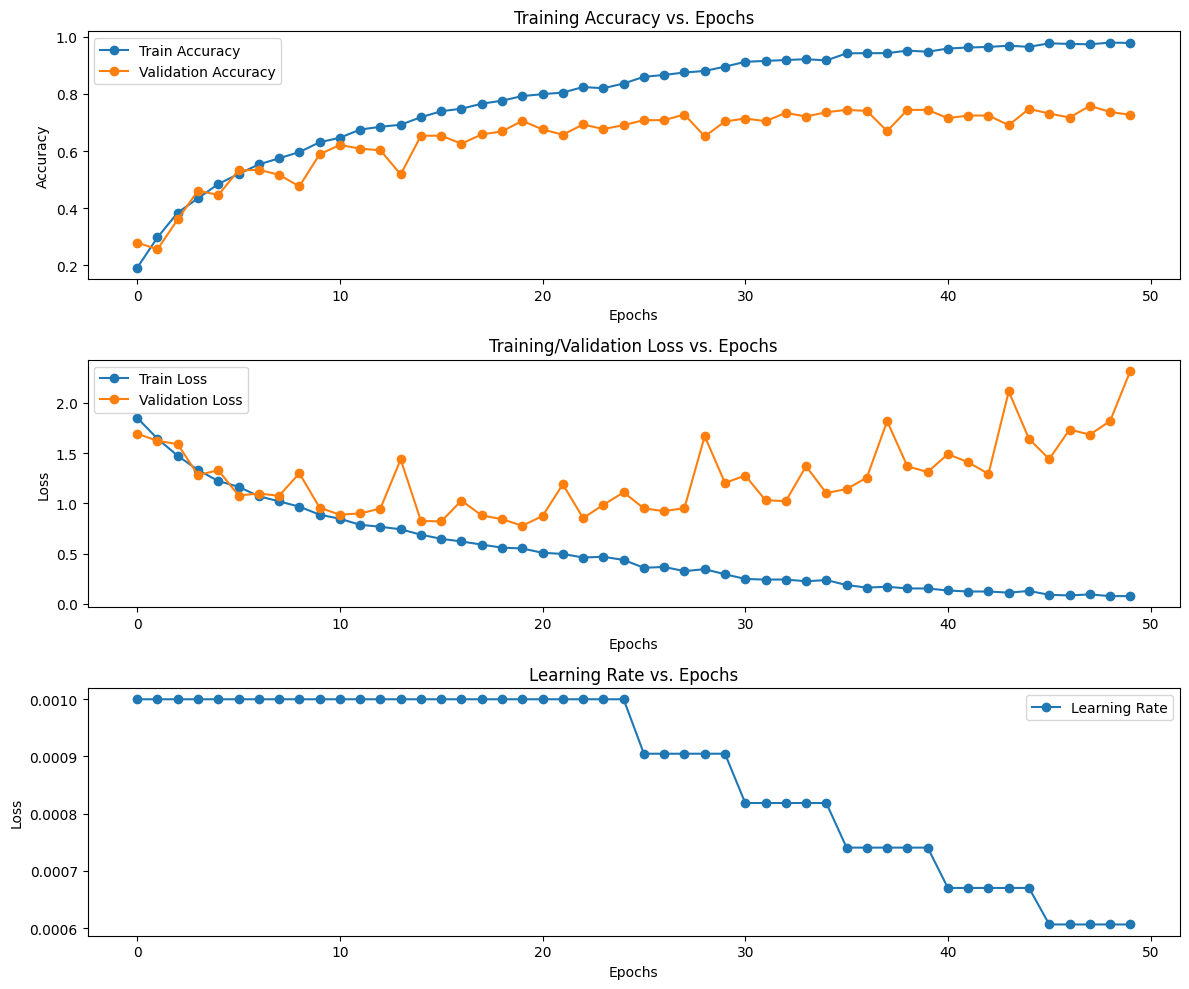

In [17]:
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

learning_rate = hist.history['lr']

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [18]:
model.save('inception4_interno')


INFO:tensorflow:Assets written to: inception4_interno/assets


INFO:tensorflow:Assets written to: inception4_interno/assets


In [19]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)



441/441 - 17s - loss: 1.5751 - accuracy: 0.7574 - 17s/epoch - 38ms/step

Test accuracy: 0.7573696374893188


-----------------------------------------------------


In [20]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : classe_1
1 : classe_2
2 : classe_3
3 : classe_4
4 : classe_5
5 : classe_6
6 : classe_7


In [27]:
model.load_weights('inception5_externo')

2022-10-25 22:27:19.493070: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open inception5_externo: FAILED_PRECONDITION: inception5_externo; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


402/402 [==============================] - 13s 33ms/step


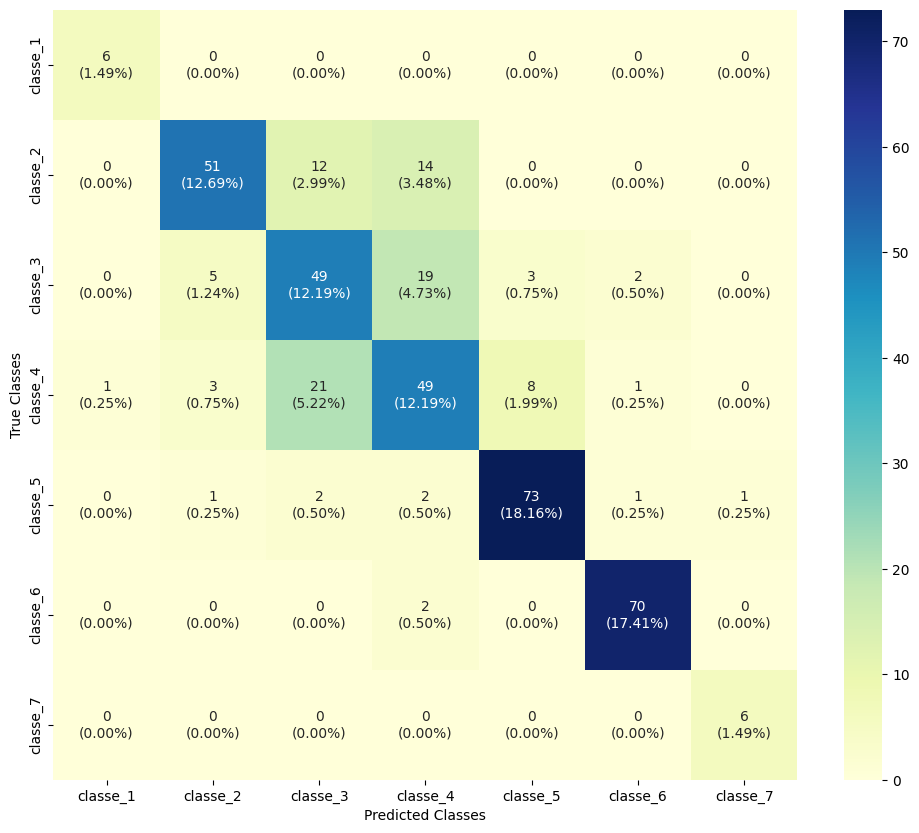

In [32]:
predictions = model.predict(test_generator)
import seaborn as sns
from tensorflow.keras.layers import Flatten
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(7, 7)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [22]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

    classe_1       0.76      1.00      0.86        22
    classe_2       0.79      0.55      0.65        82
    classe_3       0.69      0.59      0.63        82
    classe_4       0.53      0.71      0.61        84
    classe_5       0.87      0.95      0.91        83
    classe_6       0.99      0.91      0.95        82
    classe_7       1.00      0.83      0.91         6

    accuracy                           0.76       441
   macro avg       0.80      0.79      0.79       441
weighted avg       0.77      0.76      0.76       441



In [37]:
path = '/home/luan/Desktop/feijao/Classificacao-main/images/externa'

In [23]:
path_test = '/home/luan/Desktop/feijao/Classificacao-main/images/teste'

In [38]:
final_test_generator = test_datagen.flow_from_directory(
        path,
        target_size=(256, 256),
        shuffle=False,
        batch_size=1,
        class_mode='categorical')

Found 500 images belonging to 7 classes.


500/500 [==============================] - 16s 33ms/step


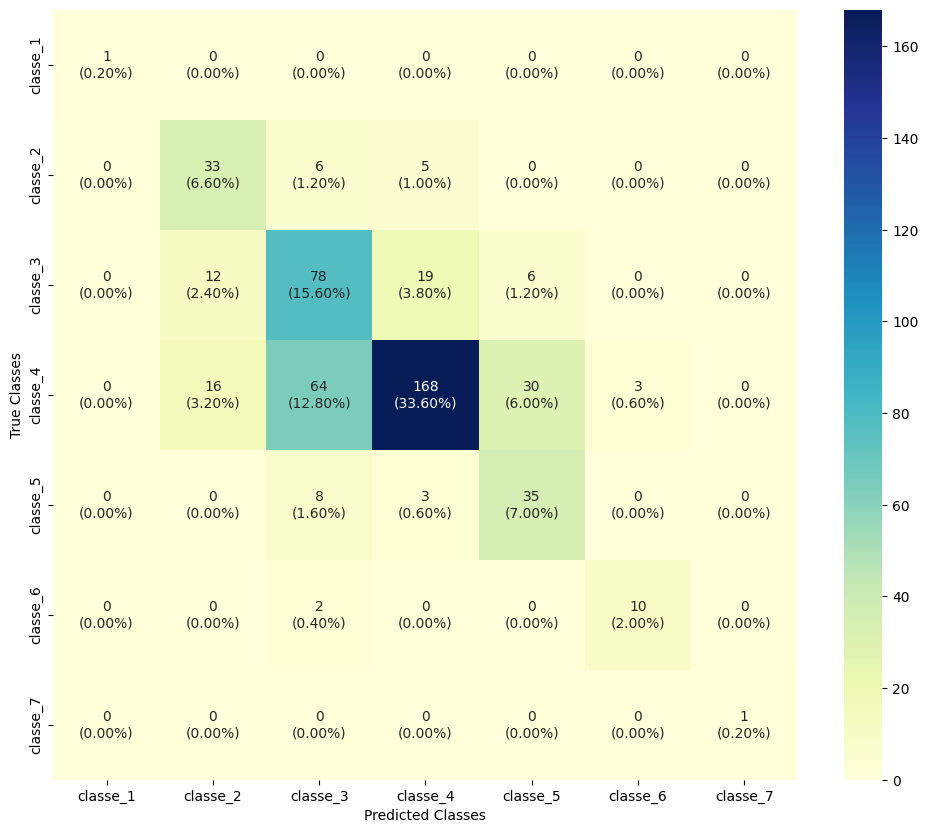

In [39]:
predictions = model.predict(final_test_generator)

y_pred = np.argmax(predictions, axis=1)
y_true = final_test_generator.classes

cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(7, 7)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [41]:
from sklearn.metrics import accuracy_score


accuracy_score(y_true, y_pred)

0.652

: 